# ノンパラベイズをゼロから理解する.

## Dirichlet process とは何か?

確率分布を離散確率分布に変換することができる.

## 棒折り過程(stick breaking process)とは何か?

Dirichlet processの実装.

## 中華料理店過程(chinese restaurant process)とは何か?

## references

1. https://en.wikipedia.org/wiki/Stochastic_process
    - 確率過程とはそもそも何か?
1. https://docs.pymc.io/notebooks/dp_mix.html
    - コードと実例
        - numpyを駆使したコードは難しいが参考になる
    - CRPについて解説は無い
2. https://qiita.com/masasora/items/5469638d93d9c834724b
    - 参考文献がたくさｎ
    - コードが無い
3. https://en.wikipedia.org/wiki/Dirichlet_process
4. https://en.wikipedia.org/wiki/Chinese_restaurant_process

$$
\begin{eqnarray}
p\left(\mathbf X \mid \mathbf Z, \boldsymbol \mu, \boldsymbol \Lambda \right)
&=& \prod_{n=1}^N\prod_{k=1}^K \left\lbrace \mathcal N \left(\mathbf x_n \mid \boldsymbol \mu_k, \boldsymbol \Lambda_k^{-1} \right) \right\rbrace^{z_{nk}} \\
p\left(\boldsymbol \mu_k, \boldsymbol \Lambda_k \mid G \right) &=& G\left(\boldsymbol \mu_k, \boldsymbol \Lambda_k \right) \\
p\left( G | \boldsymbol \alpha, G_0 \right) &=& \operatorname {DP} \left( G \mid \boldsymbol \alpha, G_0 \right) \\
G_0
&=&
    \mathcal N \left(\boldsymbol \mu \mid \mathbf m_{0}, \left(\beta_{0} \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda \mid \mathbf W_{0}, \nu_{0}\right)
\end{eqnarray}
$$

DPとかGとかがよくわからない. $G_0$は基底分布.
$GとG_0$ は同じ形, 分布の生成元となる分布, 馴染みの有る言い方に変えると, 分布パラメータの共役事前分布, つまり正規分布パラメータに対してはNormal-Wishart分布である.

DPとは, 共益事前分布から分布パラメータを, 棒折り過程から混合比を吐き出す確率過程(もしくはCRPから隠れ変数zを吐き出す過程).



$\varsigma$

$$
\begin{eqnarray}
p\left(\mathbf X \mid \mathbf Z, \boldsymbol \mu, \boldsymbol \Lambda \right)
&=& \prod_{n=1}^N\prod_{k=1}^K \left\lbrace \mathcal N \left(\mathbf x_n \mid \boldsymbol \mu_k, \boldsymbol \Lambda_k^{-1} \right) \right\rbrace^{z_{nk}} \\
p\left(\boldsymbol \mu_k, \boldsymbol \Lambda_k \right) &=&
    \mathcal N \left(\boldsymbol \mu_k \mid \mathbf m_{0}, \left(\beta_{0} \Lambda_{k} \right)^{-1}\right)
    \mathcal W\left(\boldsymbol \Lambda_k \mid \mathbf W_{0}, \nu_{0}\right)
    ,\; \forall k = 1,2,...,K \\
\mathbf Z
&\sim& \operatorname {CRP} \left( \alpha \right) \\
\end{eqnarray}
$$

### DPcdensityの処理

1. CRPでデータのZをサンプリング, $ \theta_{k} $ を更新
2. SBPで混合比をサンプリング(`rbeta(1.d0,alpha+dble(nrec))` なんだけど意味がわからｎ)
3. 各混合分布について, CRP(テーブルはデータのCRPの状態)で分布をサンプリング
4. 予測点の条件付き確率からmeanfp, denspを算出. 3.で新規テーブルを生成した場合は, 算出後に履き捨て
5. 上記を繰り返し, 予測点の事後分布を得る.

上の1. がよくあるDirichlet processの無限混合分布による推定, 2. 以降はその結果から予測分布を推定する処理.　Neal 2000. に詳しい.

変分ベイズの場合は, 2, 3, 4, 5も変分近似できるの?

$$
\eta
$$

通常の混合分布に対して, 混合数Kの事前分布をSBPとする, もしくは隠れ変数Zの事前分布をCRPとする, とディリクレ過程無限混合分布となる.
各正規分布のパラメータの事前分布はNormal-Wishart分布

CRPの確率密度関数ってやつがよくわからん. $ \operatorname{CRP} (Z \mid \alpha) $ って何?

$$
\begin{eqnarray}
p_{\operatorname {CRP}} \left( \mathbf Z \mid \alpha \right) &=& \frac {\Gamma\left(\alpha\right) \alpha^{K}} {\Gamma(\alpha + N)} \prod_{k=1}^K \Gamma \left( \left| C_{k} \right| \right)
\end{eqnarray}
$$

$ \left| C_{k} \right|  $ はk番目のクラスタのサイズ.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
blue, *_ = sns.color_palette()

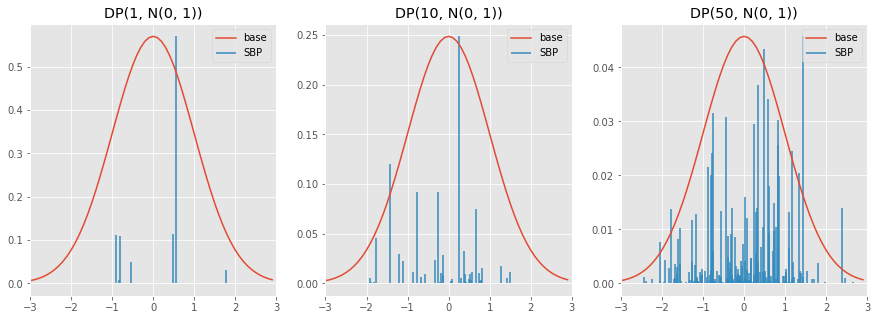

In [8]:
# Stick Breaking Process(SBP)
def stick_breaking_process(a, K=500):
    D0 = sp.stats.norm
    beta = sp.stats.beta.rvs(1, a, size=K)
    w = np.empty_like(beta)
    w[0] = beta[0]
    w[1:] = beta[1:] * (1 - beta[:-1]).cumprod()
    return D0.rvs(size=K), w

a = np.array([1, 10, 50])
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, ax in enumerate(axes):
    v, p = stick_breaking_process(a[i])
    ax.vlines(v, [0], p, colors=colors[1], label='SBP')
    ax.set_xlim(-3, 3)
    ax.set_title("DP({0}, N(0, 1))".format(a[i]))
    
    x = np.arange(-3.0, 3.0, 0.1)
    y = sp.stats.norm.pdf(x)
    y = y / y.max() * p.max()
    ax.plot(x, y, label='base')
    ax.legend()

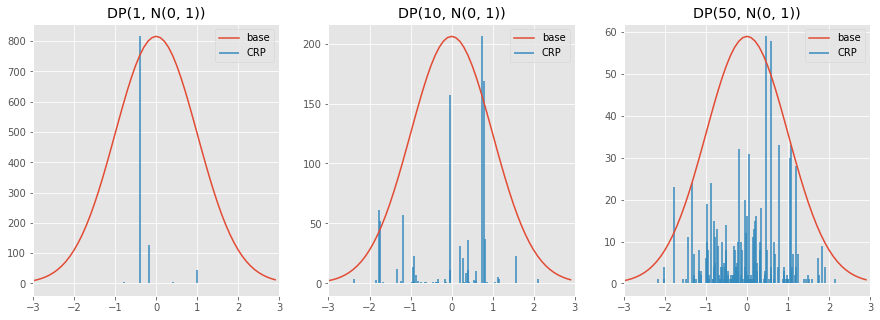

In [3]:
# Chinese Restaurant Process(CRP)
def chinese_restaurant_process(a, N=1000):
    D0 = sp.stats.norm
    tables = np.array([1, a])
    for n in np.arange(2, N+1):
        p = tables
        s = np.random.choice(tables.size, p=tables/(n-1+a))
        if(tables.size-1 == s):
            tables[s] = 1
            tables = np.append(tables, a)
        else:
            tables[s] += 1
    return D0.rvs(size=tables.size-1), tables[:-1]

a = np.array([1, 10, 50])
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
for i, ax in enumerate(axes):
    v, p = chinese_restaurant_process(a[i])
    ax.vlines(v, [0], p, colors=colors[1], label='CRP')
    ax.set_xlim(-3, 3)
    ax.set_title("DP({0}, N(0, 1))".format(a[i]))
    
    x = np.arange(-3.0, 3.0, 0.1)
    y = sp.stats.norm.pdf(x)
    y = y / y.max() * p.max()
    ax.plot(x, y, label='base')
    ax.legend()

In [3]:
SEED = 5132290 # from random.org

np.random.seed(SEED)

In [18]:
N = 1
K = 10

alpha = 2.
P0 = sp.stats.norm

In [24]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)
omega = P0.rvs(size=(N, K))

x_plot = np.linspace(-3, 3, 100)

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

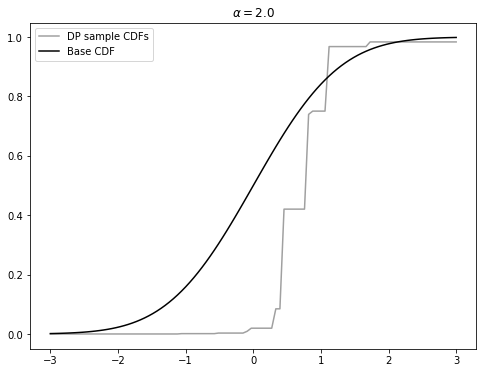

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
        label='DP sample CDFs');
# ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

ax.set_title(r'$\alpha = {}$'.format(alpha));
ax.legend(loc=2);

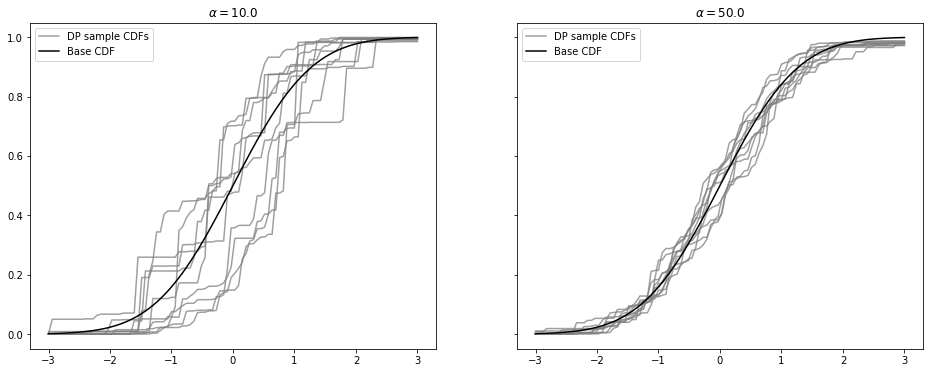

In [195]:
fig, (l_ax, r_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

K = 50
alpha = 10.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

l_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
l_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
l_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

l_ax.set_title(r'$\alpha = {}$'.format(alpha));
l_ax.legend(loc=2);

K = 200
alpha = 50.

beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

omega = P0.rvs(size=(N, K))

sample_cdfs = (w[..., np.newaxis] * np.less.outer(omega, x_plot)).sum(axis=1)

r_ax.plot(x_plot, sample_cdfs[0], c='gray', alpha=0.75,
          label='DP sample CDFs');
r_ax.plot(x_plot, sample_cdfs[1:].T, c='gray', alpha=0.75);
r_ax.plot(x_plot, P0.cdf(x_plot), c='k', label='Base CDF');

r_ax.set_title(r'$\alpha = {}$'.format(alpha));
r_ax.legend(loc=2);

In [146]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)

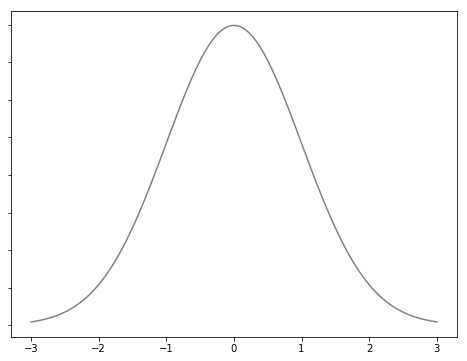

In [144]:
xx = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(xx, sp.stats.norm.pdf(xx, 0, 1), c='gray');

ax.set_yticklabels([]);

In [149]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

# mean of normal
theta = P0.rvs(size=(N, K))

x_plot = np.linspace(-3, 3, 30)
dpm_pdf_components = f(x_plot[np.newaxis, np.newaxis, :], theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

In [122]:
print(dpm_pdf_components)

[[[1.41511990e-14 1.87916455e-01 9.28299664e-32]
  [6.45022282e-32 1.76882333e-01 1.80445481e-14]
  [2.99373959e-23 1.30010890e+00 2.10037699e-21]
  [2.05174304e-09 1.83125367e-03 6.08031186e-41]
  [1.26261249e-13 1.04399242e-01 3.21126701e-33]
  [3.72332591e-64 1.42492373e-11 2.02863539e-02]
  [3.12251550e-05 6.79321052e-07 5.49790655e-52]
  [1.17352368e-31 1.95302904e-01 1.20914214e-14]
  [9.28091469e-31 2.70580770e-01 2.93464035e-15]
  [1.27239984e-33 8.78391014e-02 2.25581755e-13]
  [5.21281145e-20 1.14542696e+00 9.36299080e-25]
  [1.31575068e-51 9.20940482e-07 2.39795668e-05]
  [3.01584763e-32 1.55502785e-01 2.98276306e-14]
  [4.13479801e-40 3.02885489e-03 8.25380955e-10]
  [2.27753654e-32 1.48153812e-01 3.58518953e-14]
  [8.39954218e-26 9.86695859e-01 4.31184168e-19]
  [7.61323501e-04 8.87670809e-09 3.85022802e-57]
  [1.41053670e-15 3.15738685e-01 2.62919630e-30]
  [2.19236585e-29 4.23328183e-01 3.04083703e-16]
  [5.74043750e-26 9.59570875e-01 5.96706725e-19]
  [3.51020030e-45 1.

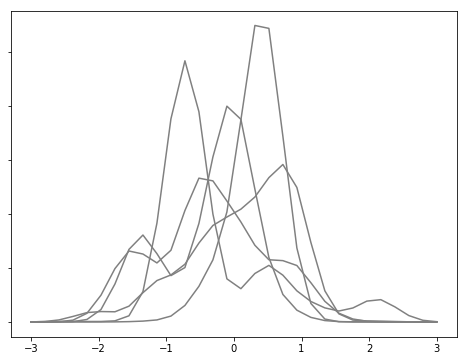

In [150]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c='gray');

ax.set_yticklabels([]);

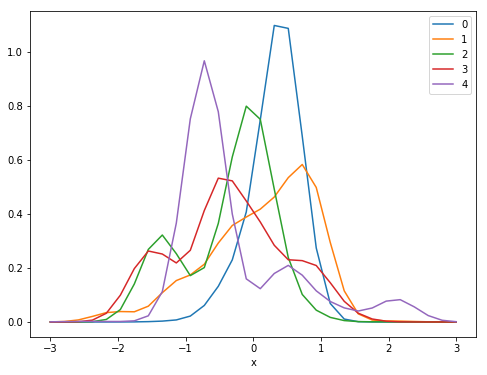

In [151]:
df = pd.DataFrame(dpm_pdfs.T)
df['x'] = x_plot
fig, ax = plt.subplots(figsize=(8, 6))
df.plot(x='x', ax=ax);

In [174]:
old_faithful_df = pd.read_csv(pm.get_data('old_faithful.csv'))
old_faithful_df['std_waiting'] = (old_faithful_df.waiting - old_faithful_df.waiting.mean()) / old_faithful_df.waiting.std()

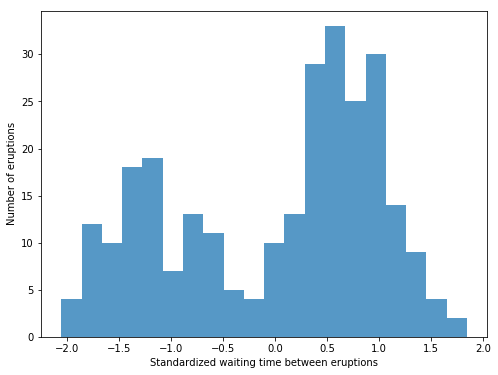

In [175]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color=blue, lw=0, alpha=0.5);
ax = old_faithful_df.std_waiting.plot.hist(bins=n_bins, color=blue, lw=0, alpha=0.5)
ax.set_xlabel('Standardized waiting time between eruptions');
ax.set_ylabel('Number of eruptions');

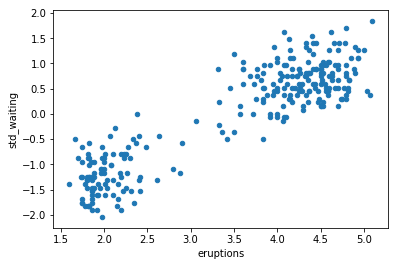

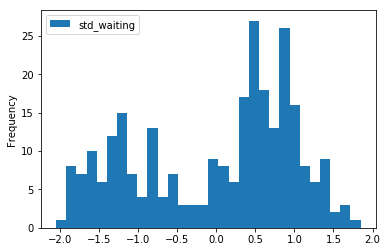

In [177]:
old_faithful_df.plot(kind='scatter', x='eruptions', y='std_waiting')
old_faithful_df.plot(kind='hist', y='std_waiting', bins=30)